# Human Activity Recognition for Healthy Lifestyle Monitoring

Group 40: Alvaro Menéndez Ros, Juan José Leguineche Gállego, Pablo Herrero Ortiz

## 1. Description and Imports

This project implements a **Human Activity Recognition system** using smartphone sensor data to classify five core daily activities: sitting down, standing up, walking, running, and climbing stairs. The solution follows a complete pipeline, including:

1. **Data Acquisition**: Collecting raw accelerometer, gravitational and gyroscope signals from smartphones during different activities.  
2. **Preprocessing**: Cleaning and segmenting noisy time-series data into structured windows.  
3. **Feature Extraction**: Deriving meaningful statistical and frequency-based features that capture movement patterns.  
4. **Model Development**: Training supervised machine learning models to distinguish between activities.  
5. **Evaluation**: Assessing model performance using accuracy, precision, recall, and confusion matrices to ensure robustness.  

By simulating real-world challenges in digital health, the system demonstrates how wearable sensor data can be transformed into actionable insights for **health monitoring and activity tracking applications**.  


In [428]:
# Python version used: 3.13.5
# Required packages: numpy, pandas, matplotlib, seaborn, scikit-learn, scipy, sklearn-extra

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, mutual_info_classif

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from scipy.signal import butter, filtfilt
from scipy.stats import skew

# Optional fuzzy C-means (pip install scikit-fuzzy)
import skfuzzy as fuzz



## 2. Data Acquisition



In [429]:
data_path = "../data/merged_data.csv"
df = pd.read_csv(data_path)

df.head()

,time,seconds_elapsed,gyro_x,gyro_y,gyro_z,acc_x,acc_y,acc_z,grav_x,grav_y,grav_z,label,session_id
0,1757685564789874000,0.000000,0.001375,0.007425,0.006875,-0.003911,-0.329490,0.012606,-1.157310,-9.492284,2.174283,sitting_down,3
1,1757685564799427000,0.009553,0.001375,0.000137,0.014300,0.019475,-0.328793,0.087064,-1.157006,-9.492508,2.173465,sitting_down,3
2,1757685564808980200,0.019106,0.000137,-0.005912,0.020350,0.011755,-0.314396,0.134700,-1.156053,-9.492723,2.173028,sitting_down,3
3,1757685564818533000,0.028659,-0.002337,-0.003575,0.020350,-0.018417,-0.341251,0.166343,-1.154445,-9.492887,2.173158,sitting_down,3
4,1757685564828086300,0.038212,-0.003575,0.000137,0.021588,-0.019810,-0.315582,0.168639,-1.152299,-9.492996,2.173811,sitting_down,3


## 3 Preprocessing


- LabelEncoder converts string labels (sitting_down, walking, etc.) into integers (0, 1, 2…) --> Most ML models need numerical labels
- drop removes identifiers (time, session_id) that shouldn’t be used as predictors.
- NORMALIZATION: Scaled with standardscaler because accelerometer and gyroscope values have different ranges, then training is easier.

No attenuation or amplification because scaling handles it, but some filtering:
- Low-pass 15Hz filter for acc and gyro

Also no decomposition (Fourier or wavelets) as its not needed.

Data aggregation: sliding windows will be used later, in feature extraction and engineering.
There is no need for synchronization as sensors are already synchronized. 

Interpolation: check if seconds_elapsed is continuous
Handling missing values: check nan values. If few, drop, if more, impute (linear interpolation) 


### 3.1 Remove unwanted class and encode labels

First, the irrelevant `"still"` class is removed and the activity labels are encoded into numeric values for later use in models.

In [430]:
# Remove still class, not useful for predictions
df = df[df["label"] != "still"]

# Encode labels
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label"])

print("Classes:", le.classes_)

Classes: ['climbing_stairs' 'running' 'sitting_down' 'standing_up' 'walking']


### 3.2 Raw visualizations

Before any preprocessing, we visualize the raw sensor signals across sessions and activities to understand their behavior and detect potential noise or irregularities.

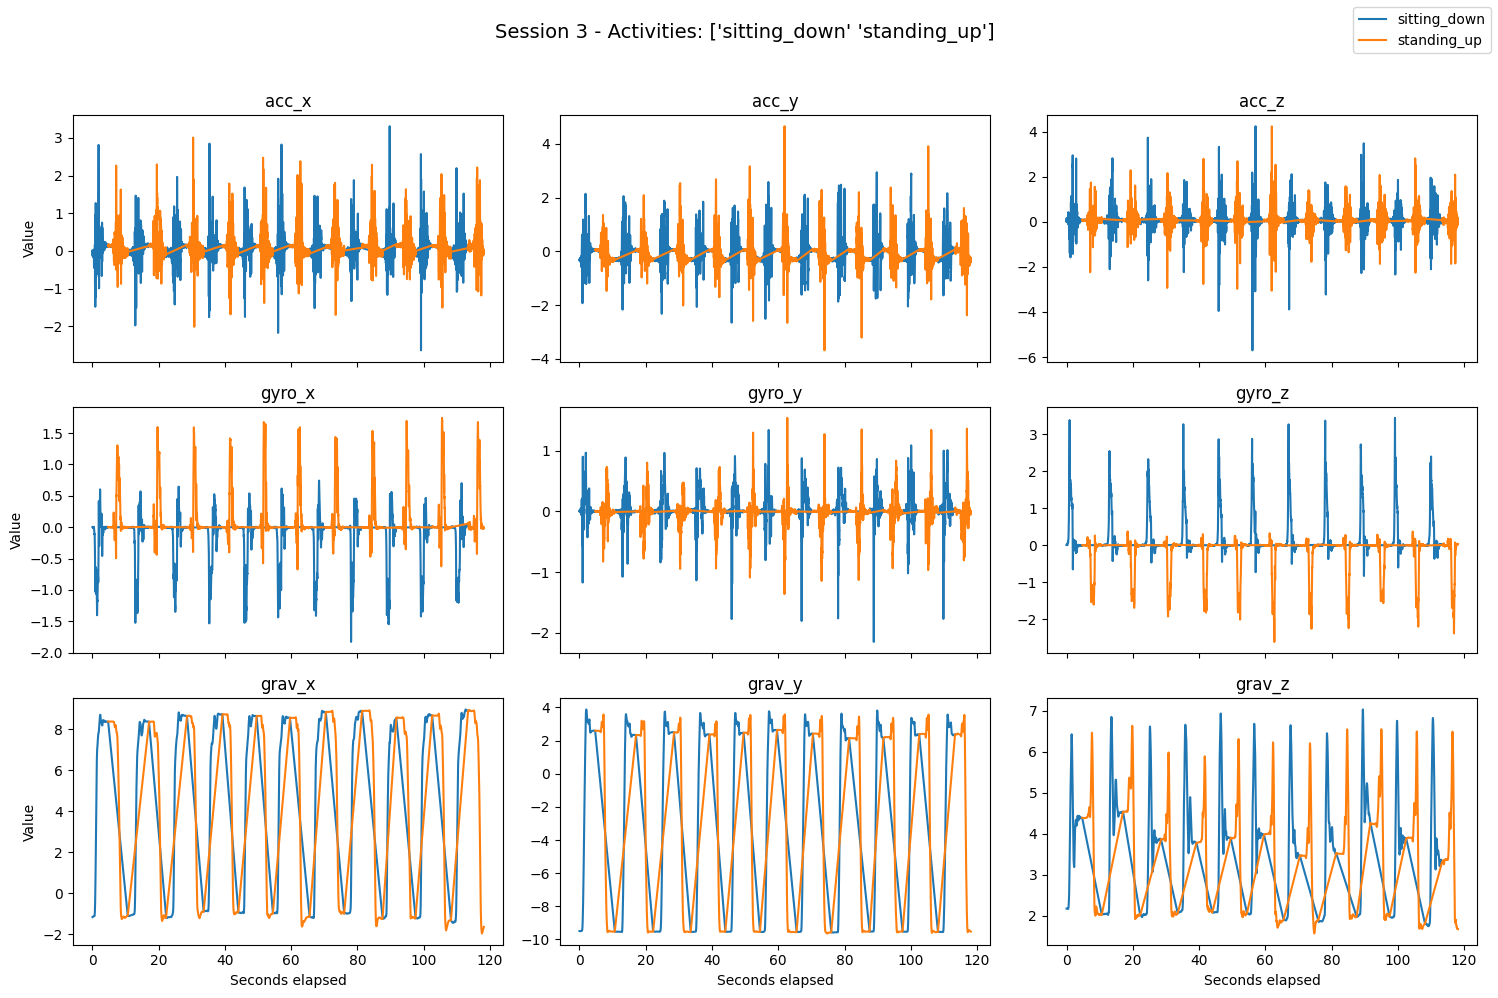

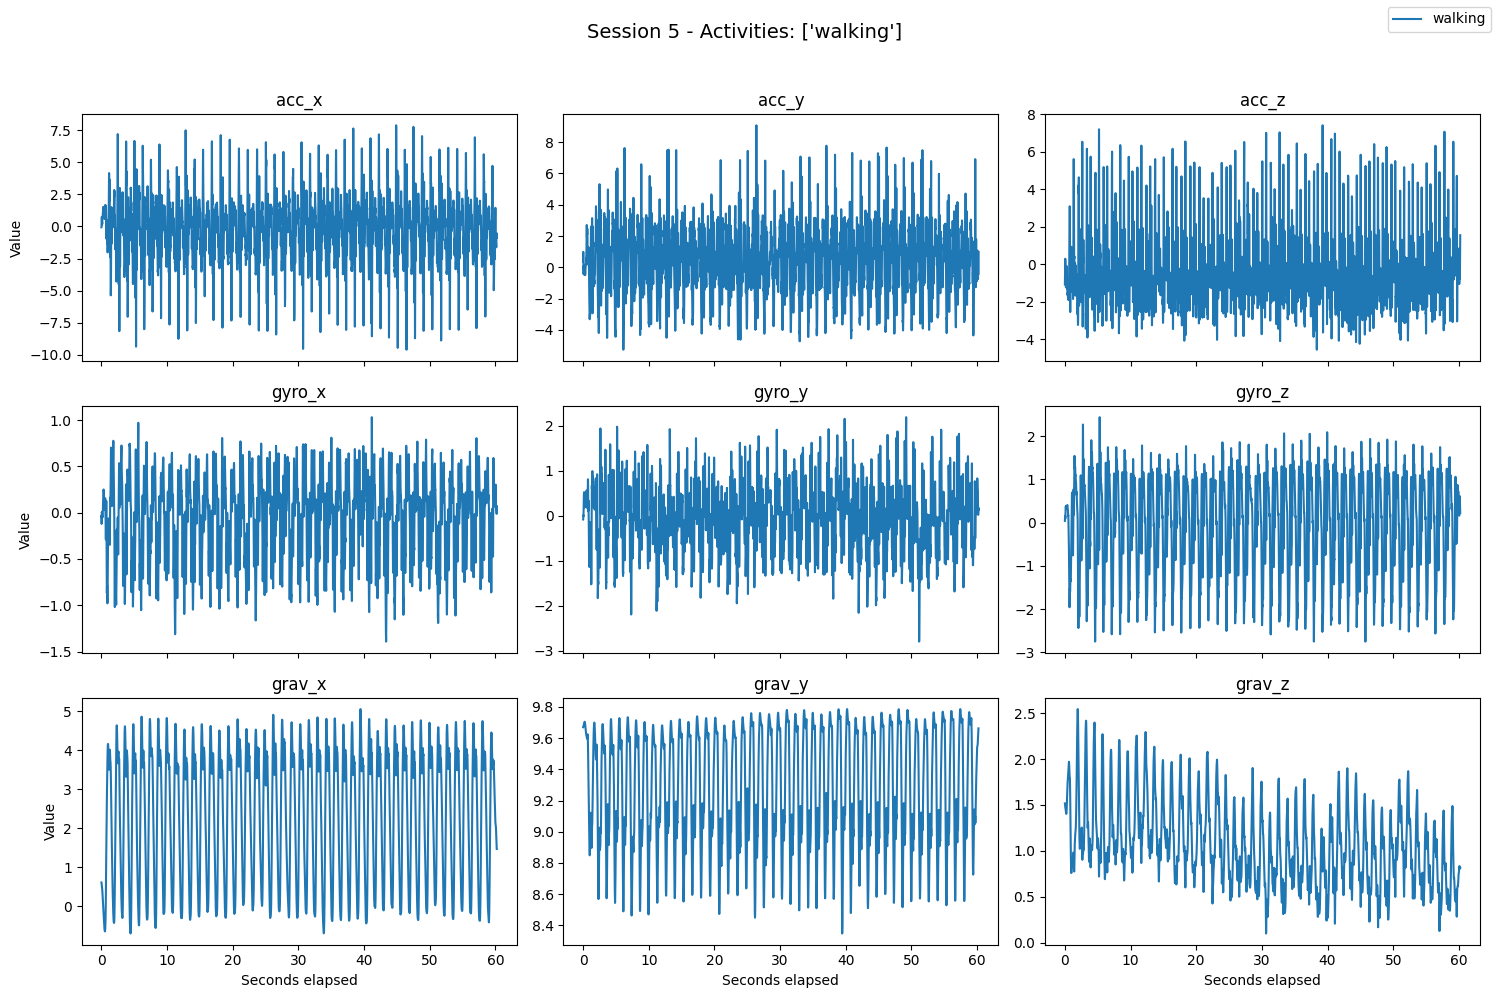

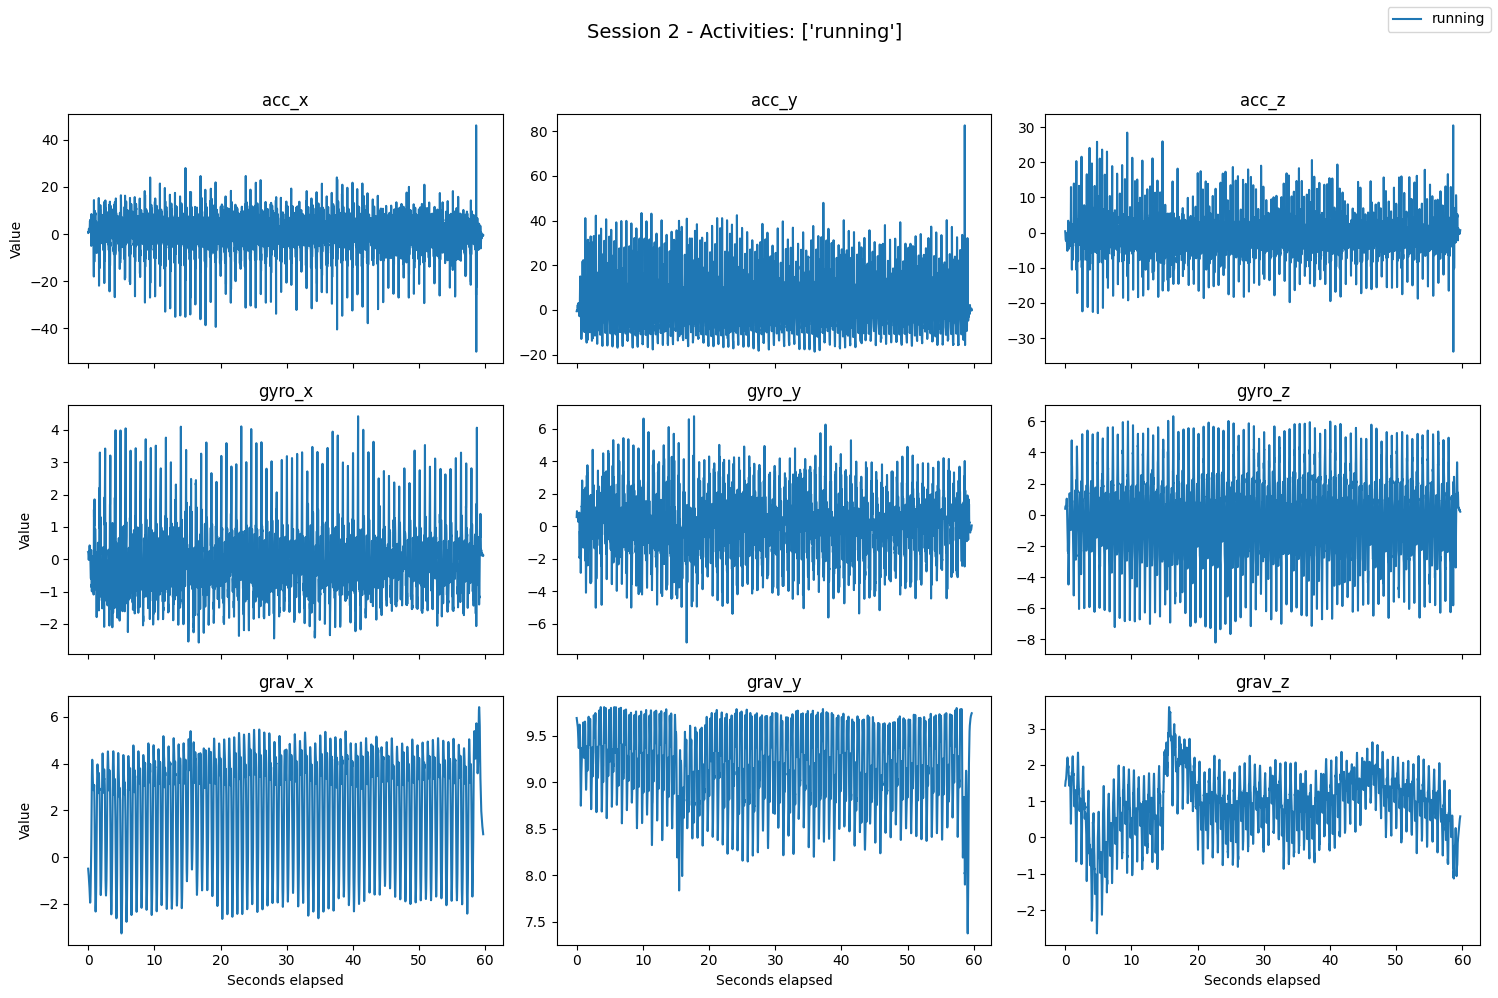

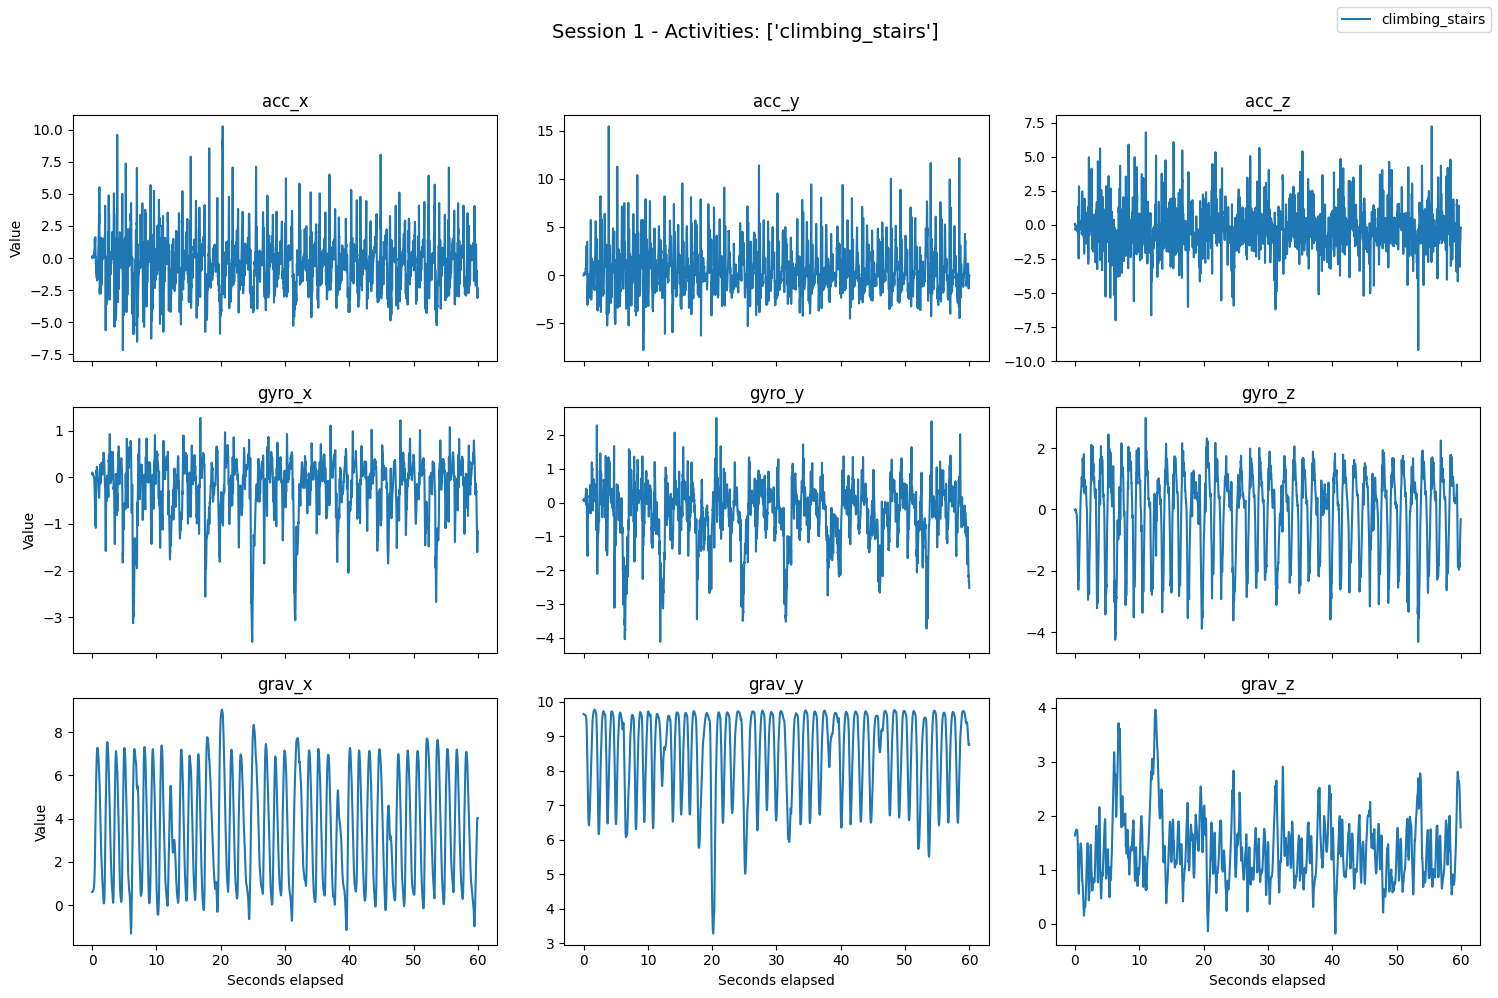

In [431]:
sensors = ["acc", "gyro", "grav"]
axes = ["x", "y", "z"]

# Loop over sessions
for session_id in df["session_id"].unique():
    df_session = df[df["session_id"] == session_id]

    fig, axs = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
    fig.suptitle(f"Session {session_id} - Activities: {df_session['label'].unique()}", fontsize=14)

    for i, sensor in enumerate(sensors):
        for j, axis in enumerate(axes):
            col = f"{sensor}_{axis}"
            ax = axs[i, j]

            # plot each activity segment in a different color
            for label in df_session["label"].unique():
                subset = df_session[df_session["label"] == label]
                ax.plot(subset["seconds_elapsed"], subset[col], label=label)

            ax.set_title(col)
            if i == 2:
                ax.set_xlabel("Seconds elapsed")
            if j == 0:
                ax.set_ylabel("Value")

    # Upper-right legend (useful for session 3)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


### 3.3 Diagnostics

Missing values are checked by counting NaN entries per column. In case they are not zero, dropping the entries or imputing the values must be considered.

The sampling frequency consistency is validated with Δt (time difference between samples): `Δt` ≈ 0.01s at 100 Hz. Moreover, a low standard deviation means stable sampling, while a high std indicates irregular timing or dropped samples.

FFTs are also performed on selected signals to inspect frequency content and justify filtering. They help identify the motion-related band (<15 Hz) versus noise.

In [432]:
def diagnostics(df, fs=100, do_fft=False, fft_session=None, fft_measurements=None):
    """
    Run diagnostics on the dataset:
    - Missing values (all columns)
    - Δt stats per session
    - Optionally: FFT for one session and selected measurements
    """
    # Check NaN values
    print("🔹 Missing values per column:")
    print(df.isna().sum())
    
    # Check frequency per session: seconds_elapsed continuity. Mean should be ≈ 0.01 and std small
    print("\n🔹 Δt stats per session:")
    for session_id in df["session_id"].unique():
        df_sess = df[df["session_id"] == session_id]
        diffs = df_sess["seconds_elapsed"].diff().dropna()
        print(f"Session {session_id}: "
              f"mean Δt = {diffs.mean():.5f}s, "
              f"std = {diffs.std():.5f}s, "
              f"expected ~{1/fs:.3f}s, "
              f"unique Δt (first 3) = {diffs.unique()[:3]}")
    
    # Optional FFT
    if do_fft and fft_session is not None and fft_measurements is not None:
        df_sess = df[df["session_id"] == fft_session]
        n = len(df_sess)
        freqs = np.fft.rfftfreq(n, d=1/fs)

        cols = 3
        rows = int(np.ceil(len(fft_measurements) / cols))
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3*rows))

        for i, meas in enumerate(fft_measurements):
            r, c = divmod(i, cols)
            ax = axes[r, c] if rows > 1 else axes[c]
            fft_vals = np.abs(np.fft.rfft(df_sess[meas].values))
            ax.plot(freqs, fft_vals)
            ax.set_title(f"{meas}")
            ax.set_xlim(0, fs/2)
            ax.set_xlabel("Hz")
            ax.set_ylabel("Magnitude")

        plt.suptitle(f"FFT plots (Session {fft_session})", fontsize=14)
        plt.tight_layout()
        plt.show()

🔹 Missing values per column:
time               0
seconds_elapsed    0
gyro_x             0
gyro_y             0
gyro_z             0
acc_x              0
acc_y              0
acc_z              0
grav_x             0
grav_y             0
grav_z             0
label              0
session_id         0
label_encoded      0
dtype: int64

🔹 Δt stats per session:
Session 3: mean Δt = 0.00962s, std = 0.00081s, expected ~0.010s, unique Δt (first 3) = [0.00955298 0.00955322 0.00955298]
Session 5: mean Δt = 0.00995s, std = 0.00000s, expected ~0.010s, unique Δt (first 3) = [0.0099541  0.00995386 0.00995386]
Session 2: mean Δt = 0.00995s, std = 0.00000s, expected ~0.010s, unique Δt (first 3) = [0.00995386 0.0099541  0.00995508]
Session 1: mean Δt = 0.00995s, std = 0.00000s, expected ~0.010s, unique Δt (first 3) = [0.00995386 0.0099541  0.00995508]


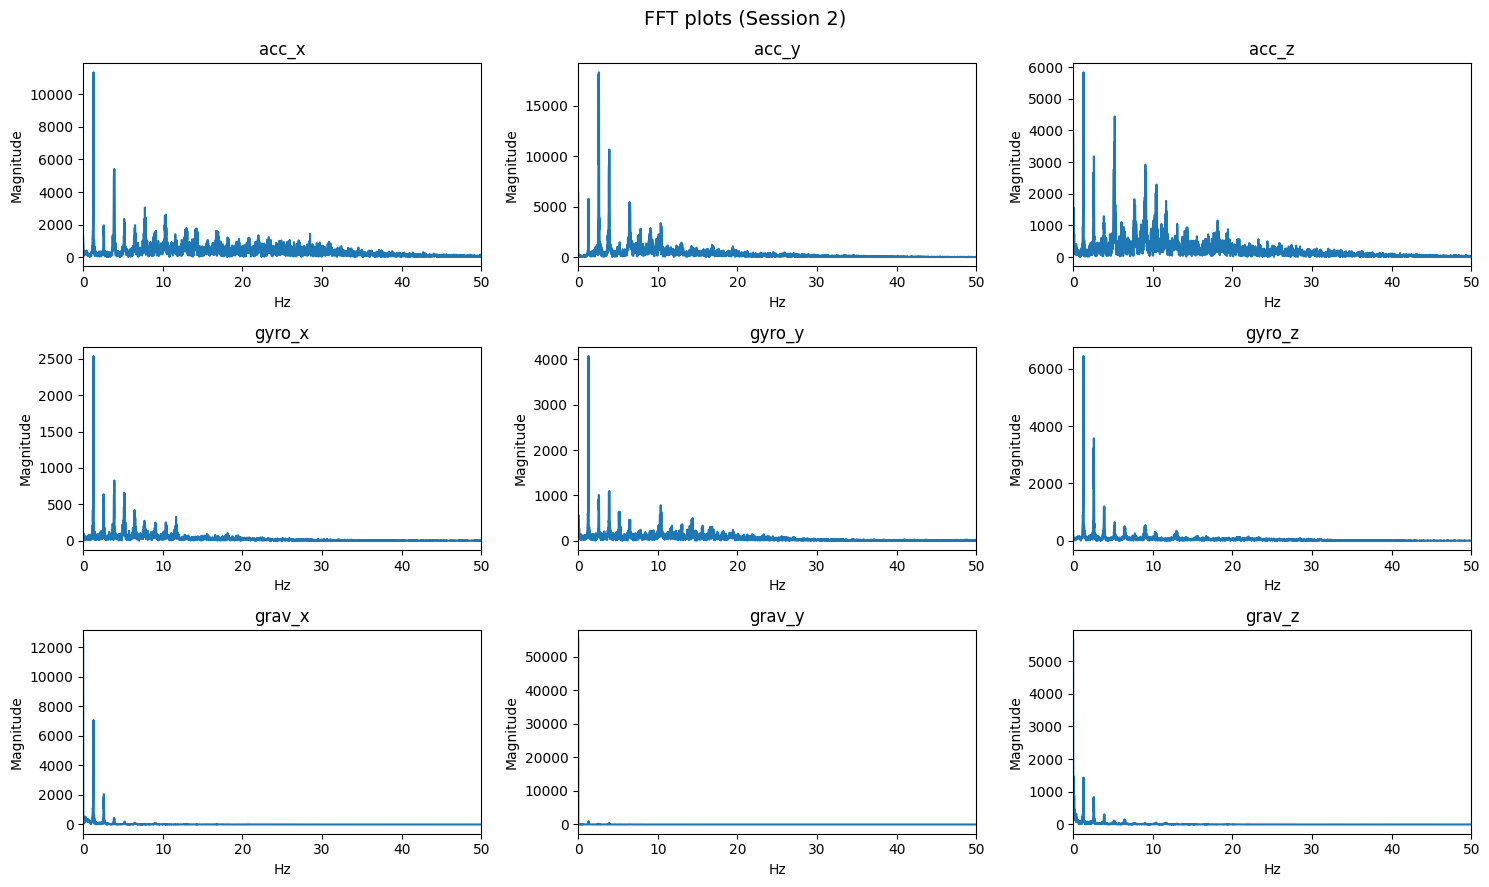

In [433]:
# Extended diagnostics: FFT for session 2 on acc, gyro, grav
diagnostics(
    df,
    fs=100,
    do_fft=True,
    fft_session=2,
    fft_measurements=["acc_x", "acc_y", "acc_z",
                      "gyro_x", "gyro_y", "gyro_z",
                      "grav_x", "grav_y", "grav_z"]
)

Results indicate that a low-pass filter might be needed, mainly shown in acc_x and acc_z graphs. Therefore, we proceed to filtering.

### 3.4 Filtering

Applied a 15 Hz low-pass Butterworth filter to accelerometer and gyroscope signals, since human activity occurs below 15 Hz. 
This is a standard practice in Human Activity Recognition to remove high-frequency noise. 

A band-pass (0.3–15 Hz) could have been applied to accelerometer data, but since gravity is already provided separately, 
the low-pass was sufficient and less complex. Gravity channels were left untouched.

In [434]:
def butter_filter(data, cutoff, fs=100, order=4, btype="low"):
    """
    Apply Butterworth filter.
    cutoff : cutoff frequency in Hz
    fs     : sampling frequency (Hz), default 100
    order  : filter order
    btype  : 'low' for low-pass, 'high' for high-pass
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    return filtfilt(b, a, data)

In [435]:
# Apply low-pass filtering (15 Hz) to accelerometer & gyroscope
for sensor in ["acc", "gyro"]:
    for axis in ["x", "y", "z"]:
        col = f"{sensor}_{axis}"
        df[col] = butter_filter(df[col], cutoff=15, btype="low")

### 3.5 Post-filter visualizations

A (previously confflictlive) FFT is replotted to confirm that filtering reduced noise while preserving the relevant motion information.  

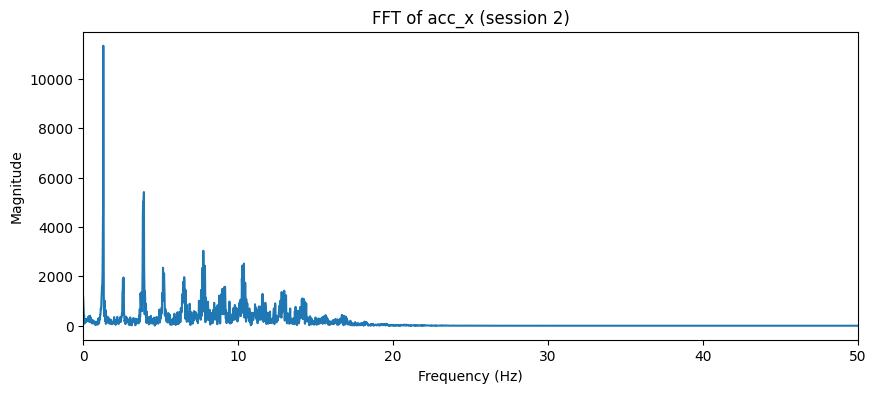

In [436]:
def plot_fft(signal, fs=100, title="FFT"):
    n = len(signal)
    freqs = np.fft.rfftfreq(n, d=1/fs)
    fft_vals = np.abs(np.fft.rfft(signal))

    plt.figure(figsize=(10,4))
    plt.plot(freqs, fft_vals)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.xlim(0, 50)  # only show up to 50 Hz (Nyquist = 50Hz at fs=100Hz)
    plt.show()

# We use accelerometer X in the same session as before
df_sess = df[df["session_id"] == 2]
plot_fft(df_sess["acc_x"].values, fs=100, title="FFT of acc_x (session 2)")


Two violin plots are also used to check separability of activities after preprocessing.

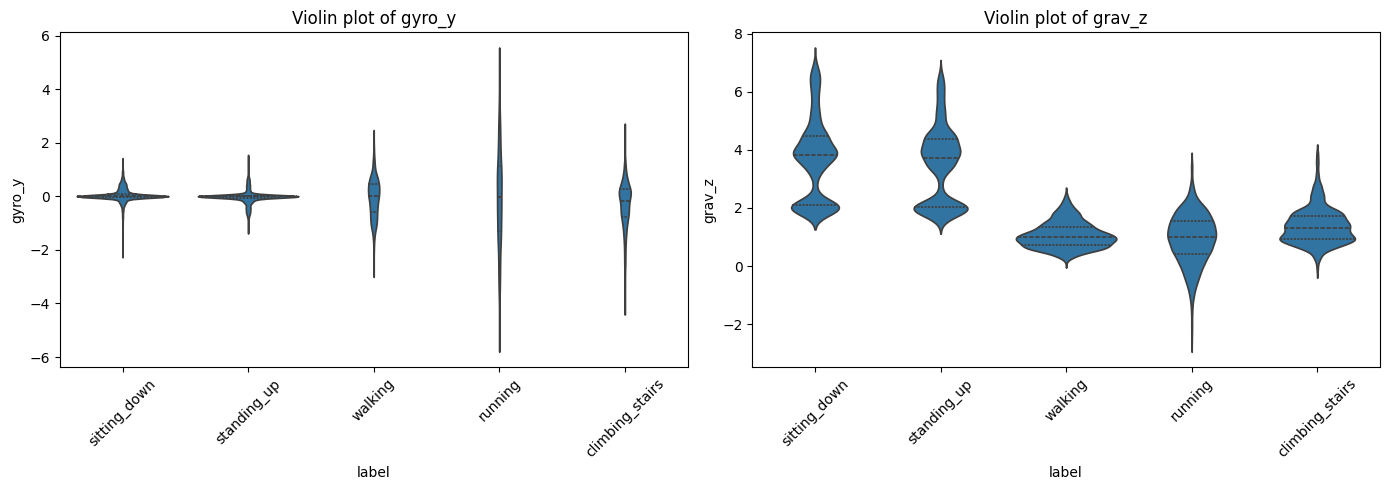

In [437]:
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=False)

sns.violinplot(data=df, x="label", y="gyro_y", inner="quartile", ax=axes[0])
axes[0].set_title("Violin plot of gyro_y")
axes[0].tick_params(axis='x', rotation=45)

sns.violinplot(data=df, x="label", y="grav_z", inner="quartile", ax=axes[1])
axes[1].set_title("Violin plot of grav_z")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Result: the final dataset ready for model training.

## 4. Feature Engineering & Extraction

### 4.1 Windowing and Feature extraction

mean, std, min, max, median, skew, RMS → 7 stats per feature

9 raw signals (acc/gyro/grav × 3 axes) → 9 × 7 = 63 features per window

In [438]:
# Parameters
window_size = 200   # 2s at 100Hz = 200 samples
step_size = 100     # 50% overlap
min_fraction = 0.6  # at least 60% of samples same label    

features, labels, session_ids = [], [], []

for session_id, df_sess in df.groupby("session_id"):   # loop per session
    X_sess = df_sess.drop(columns=["time","seconds_elapsed","label","session_id","label_encoded"])
    y_sess = df_sess["label_encoded"].values
    
    for start in range(0, len(X_sess) - window_size + 1, step_size):
        end = start + window_size
        window = X_sess.iloc[start:end]
        window_labels = y_sess[start:end]
        
        # skip mixed labels windows
        majority_label = pd.Series(window_labels).mode()[0]
        frac = np.mean(window_labels == majority_label)
        if frac < min_fraction:
            continue
        
        feats = []
        for col in window.columns:
            vals = window[col].values
            feats.extend([
                vals.mean(),
                vals.std(),
                vals.min(),
                vals.max(),
                np.median(vals),
                skew(vals),
                np.sqrt(np.mean(vals**2))   # RMS
            ])
        
        features.append(feats)
        labels.append(majority_label)
        session_ids.append(session_id)

X_feat = pd.DataFrame(features)
y_feat = np.array(labels)

print("Feature matrix shape:", X_feat.shape)
print("Labels distribution:", np.bincount(y_feat))

Feature matrix shape: (287, 63)
Labels distribution: [59 58 55 56 59]


### 4.2 Scaling

Filtered features are standardized (zero mean, unit variance) so all sensor axes are on the same scale. 

This ensures features with larger magnitudes  don’t dominate the model.

In [439]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_feat)

print("Scaled feature matrix shape:", X_scaled.shape)

Scaled feature matrix shape: (287, 63)


### 4.3 Filter feature scaling (Mutual Information)

Measures how much each feature reduces uncertainty about the class label. This is because features with higher MI are more discriminative for separating activities.

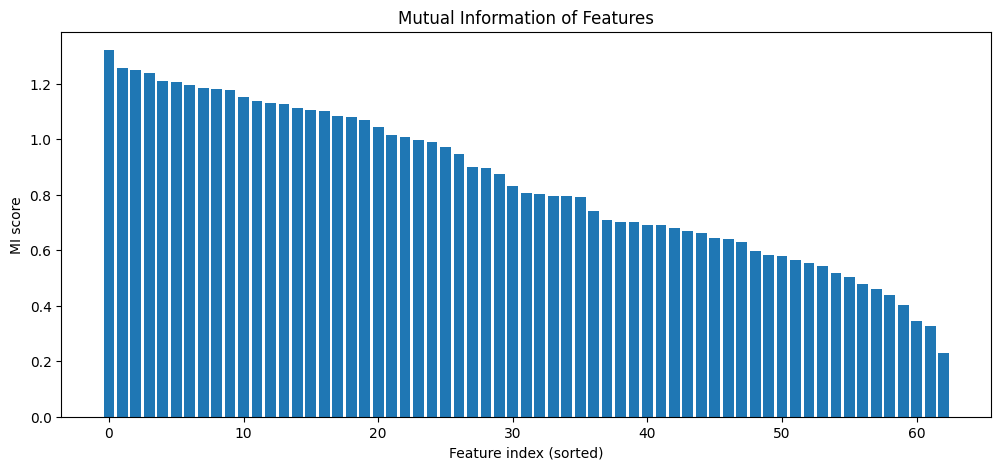

Shape after MI: (287, 36)


In [440]:
mi = mutual_info_classif(X_scaled, y_feat, random_state=42)
mi_sorted = np.argsort(mi)[::-1]

plt.figure(figsize=(12,5))
plt.bar(range(len(mi)), mi[mi_sorted])
plt.title("Mutual Information of Features")
plt.xlabel("Feature index (sorted)")
plt.ylabel("MI score")
plt.show()

# Keep top-k features: no major drops, but decided to cut on 36 
k = 36
X_mi = X_scaled[:, mi_sorted[:k]]
print("Shape after MI:", X_mi.shape)

### 4.4 Wrapper feature selection (RFE)

Iteratively trains a model (here: Logistic Regression), removes the least important features, and repeats until only the best features remain.

This is wrapper method, which selects features based on model performance, not just statistics. We will keep 25 features.

In [441]:
# Logistic regression as a baseline estimator
estimator = LogisticRegression(max_iter=500)
rfe = RFE(estimator, n_features_to_select=25)
rfe.fit(X_mi, y_feat) # Use X_mi instead of X_scaled

X_final = X_mi[:, rfe.support_] # Apply mask to reduced MI set
print("Shape after RFE:", X_final.shape)
print("Selected features:", np.where(rfe.support_)[0])

Shape after RFE: (287, 25)
Selected features: [ 0  1  2  3  4  6  7  8  9 10 14 15 18 21 22 23 24 25 26 27 28 29 31 32
 35]


## 5. Cross Validation and Splitting

CV provides an estimate of model stability by training and testing across multiple folds, while a single train/test split simulates real deployment by holding out unseen data for final evaluation.


### 5.1 Cross Validation

It is applied to evaluate model performance and stability. 

Since each session typically contains only one activity, `GroupKFold` is not suitable (it would leave out unseen classes).  
Instead, we use `StratifiedKFold`, which ensures that each fold preserves the label distribution, giving a fair estimate of how well the models generalize across balanced splits.

In [442]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Cross-validation results (F1-weighted, StratifiedKFold):")
for name, model in models.items():
    scores = cross_val_score(
        model,
        X_final,
        y_feat,
        cv=skf,
        scoring="f1_weighted"
    )
    print(f"{name:12s}: {scores.mean():.3f} ± {scores.std():.3f}")



Cross-validation results (F1-weighted, StratifiedKFold):
LogReg      : 0.961 ± 0.017
DecisionTree: 0.944 ± 0.021
NaiveBayes  : 0.910 ± 0.049
KNN         : 0.941 ± 0.024


The reported metric is **F1-weighted**, which balances precision and recall across all classes, taking class frequencies into account.  
This is more informative than accuracy when classes are not perfectly balanced.  
Results around 0.9–0.95 show that our statistical features provide strong discrimination between activities, with low variability across folds (± values), meaning the models are stable.

### 5.2 Splitting
After validating our features and models through cross-validation, we move to a supervised learning setup with a single train/test split.  
This allows us to train a final model on the training set and evaluate it on a held-out test set, simulating performance on unseen data.

In [443]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_feat, test_size=0.2, random_state=42, stratify=y_feat
)

## 6. Supervised Learning

In [444]:
models = {
    "LogReg": LogisticRegression(max_iter=5000, solver="saga"),
    "DecisionTree": DecisionTreeClassifier(),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    results[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "F1": f1_score(y_test, preds, average="weighted"),
        "Kappa": cohen_kappa_score(y_test, preds),
        "Confusion": confusion_matrix(y_test, preds)
    }

results

{'LogReg': {'Accuracy': 0.9655172413793104,
  'F1': 0.9655172413793104,
  'Kappa': 0.9568773234200744,
  'Confusion': array([[12,  0,  0,  0,  0],
         [ 0, 12,  0,  0,  0],
         [ 0,  0, 10,  1,  0],
         [ 0,  0,  1, 10,  0],
         [ 0,  0,  0,  0, 12]])},
 'DecisionTree': {'Accuracy': 0.9482758620689655,
  'F1': 0.9479585207396302,
  'Kappa': 0.9353159851301115,
  'Confusion': array([[11,  0,  0,  0,  1],
         [ 0, 12,  0,  0,  0],
         [ 0,  0, 11,  0,  0],
         [ 0,  0,  2,  9,  0],
         [ 0,  0,  0,  0, 12]])},
 'NaiveBayes': {'Accuracy': 0.9827586206896551,
  'F1': 0.9827229242521596,
  'Kappa': 0.9784386617100371,
  'Confusion': array([[12,  0,  0,  0,  0],
         [ 0, 12,  0,  0,  0],
         [ 0,  0, 10,  1,  0],
         [ 0,  0,  0, 11,  0],
         [ 0,  0,  0,  0, 12]])},
 'KNN': {'Accuracy': 0.9827586206896551,
  'F1': 0.9827229242521596,
  'Kappa': 0.9784386617100371,
  'Confusion': array([[12,  0,  0,  0,  0],
         [ 0, 12,  0,  0

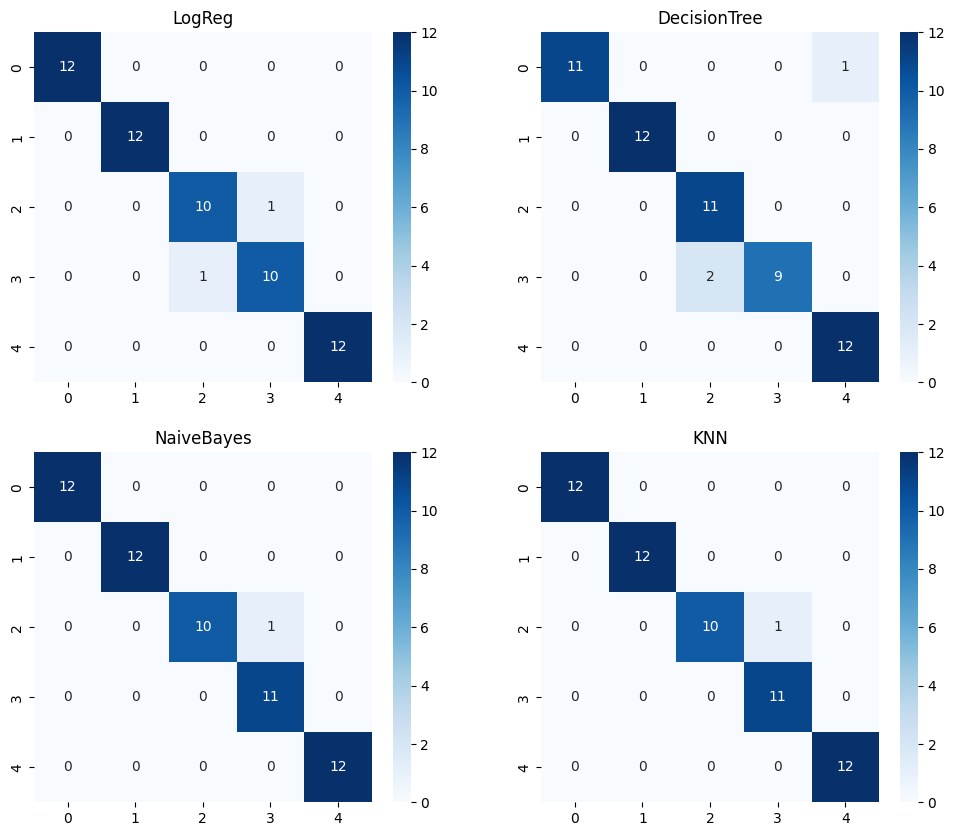

In [445]:
# Plot confusion matrices
fig, axes = plt.subplots(2,2, figsize=(12,10))
for ax,(name,res) in zip(axes.flatten(), results.items()):
    sns.heatmap(res["Confusion"], annot=True, fmt="d", ax=ax, cmap="Blues")
    ax.set_title(name)
plt.show()

### Results explanation

- Logistic regression benefits from scaling and well-engineered features.

- Trees handle mixed features well.

- Naive Bayes sometimes suffers when features are correlated, but still does okay.

- KNN struggles when classes overlap in feature space (walking vs. standing_up, both being moderate-intensity movements). When added scaling, results are improved significantly

## Unsupervised Learning

In [446]:
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_feat)

# K-Means
kmeans = KMeans(n_clusters=len(le.classes_), random_state=42).fit(X_feat)
kmeans_labels = kmeans.labels_

# Gaussian Mixture
gmm = GaussianMixture(n_components=len(le.classes_), random_state=42).fit(X_feat)
gmm_labels = gmm.predict(X_feat)

# Fuzzy C-Means
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    X_feat.T, c=len(le.classes_), m=2, error=0.005, maxiter=1000, init=None)
fcm_labels = np.argmax(u, axis=0)

unsup_labels = {"KMeans": kmeans_labels, "GMM": gmm_labels, "FuzzyCMeans": fcm_labels}

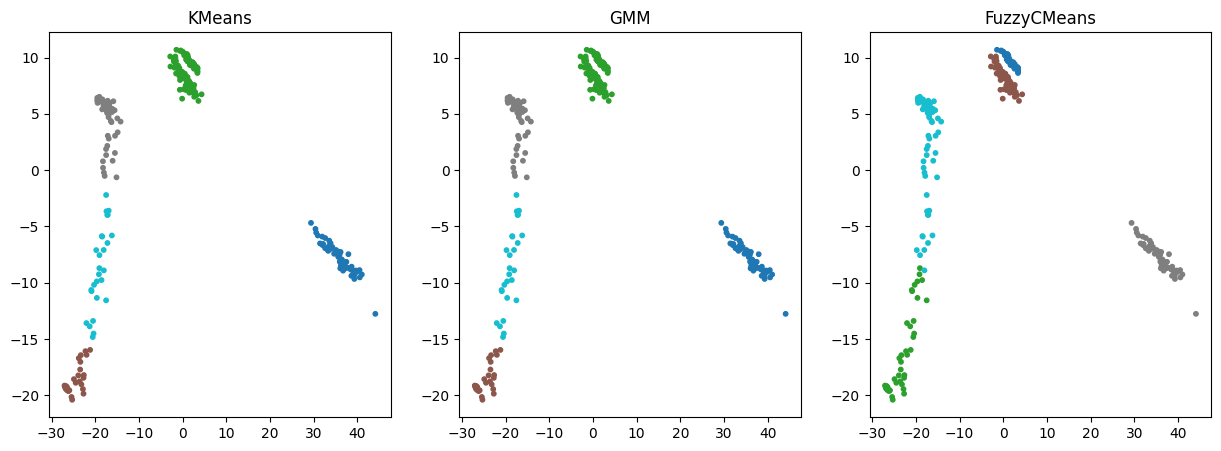

In [447]:
# Plot clustering results in PCA space
fig, axes = plt.subplots(1,3, figsize=(15,5))
for ax,(name, labels_) in zip(axes, unsup_labels.items()):
    scatter = ax.scatter(X_pca[:,0], X_pca[:,1], c=labels_, cmap="tab10", s=10)
    ax.set_title(name)
plt.show()

## Model Comparison

In [448]:
# Supervised comparison table
supervised_df = pd.DataFrame(results).T[["Accuracy","F1","Kappa"]]
print(supervised_df)

# Example unsupervised evaluation: Adjusted Rand Index vs true labels
from sklearn.metrics import adjusted_rand_score

unsup_scores = {name: adjusted_rand_score(y_feat, labels_) for name, labels_ in unsup_labels.items()}
unsup_scores

              Accuracy        F1     Kappa
LogReg        0.965517  0.965517  0.956877
DecisionTree  0.948276  0.947959  0.935316
NaiveBayes    0.982759  0.982723  0.978439
KNN           0.982759  0.982723  0.978439


{'KMeans': 0.550567852700264,
 'GMM': 0.550567852700264,
 'FuzzyCMeans': 0.7641145294704006}

## Evaluation

In [449]:
# Identify best model
best_model = supervised_df["Accuracy"].idxmax()
print("Best performing supervised model:", best_model)

# Save summary
#supervised_df.to_csv("../data/supervised_results.csv")
#pd.DataFrame.from_dict(unsup_scores, orient="index", columns=["ARI"]).to_csv("../data/unsupervised_results.csv")

Best performing supervised model: NaiveBayes
